In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime, timedelta
import utils
import LGBM003_config
import inspect

def class_to_df(cfg_class):
    class_name = cfg_class.__name__
    attributes = [attr for attr in dir(cfg_class) if not callable(getattr(cfg_class, attr)) and not attr.startswith("__")]
    data = {attr: [getattr(cfg_class, attr)] for attr in attributes}
    data['class_name'] = [class_name]
    return pd.DataFrame(data)

# オプティカルフローの予測精度

In [26]:
id_all_data = pd.read_csv("H:\study\output\StackingOpt\EDA006\id_all_data.csv")
id_all_data.head()

,id,id_lat,id_lng,id_lat_mesh,id_lng_mesh,id_prefecture,pvrate,observed_max,observed_max2
0,6,35.81228,139.72822,35.82,139.72,埼玉県,3.42,3014.2112,NaN
1,9,31.92295,131.44116,31.92,131.44,宮崎県,3.00,NaN,NaN
2,12,35.67967,139.82913,35.68,139.82,東京都,6.02,4502.4124,NaN
3,14,35.09792,136.88363,35.10,136.88,愛知県,4.13,3556.2000,NaN
4,17,35.50329,139.69705,35.50,139.70,神奈川県,2.79,2032.7072,NaN


In [27]:
folder_path = "H:/study/preprocessing_data/1_twoweeks_nv"

id_list = []
files = os.listdir(folder_path)
for file in files:
    id_list.append(int(file.split(".")[0]))

common_ids = id_all_data[id_all_data.id.isin(id_list)].id.tolist()
common_ids = [str(num).zfill(10) for num in common_ids]
common_ids_path  = [folder_path+f"/{id}.csv" for id in common_ids]

In [35]:
df_list = []
for path in common_ids_path :
    df = pd.read_csv(path, header=None, index_col=None)
    df.columns = ["year","month","day","hour","flag","nv","two_weeks_max"]
    id = int(path.split("/")[-1].split(".")[0])
    df["id"] = int(id)
    df_list.append(df)
    if i%int(len(common_ids_path)*0.1) == 0:
        print(f"{i/len(common_ids_path)*100}_finish")
    break

df = pd.concat(df_list) 
df = pd.concat(df_list) 
df["year"] += 2000
df["minute"] = df["hour"]%1*60
df["hour"] = df["hour"]//1
df[["hour","minute"]] = df[["hour","minute"]].astype(int)
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])
df.drop(["year","month","day","hour","minute"],axis=1,inplace=True)

df = df.merge()

In [37]:
df

,flag,nv,two_weeks_max,id,datetime
0,0,0.0,0.0,551,2013-08-01 00:00:00
1,0,0.0,0.0,551,2013-08-01 00:30:00
2,0,0.0,0.0,551,2013-08-01 01:00:00
3,0,0.0,0.0,551,2013-08-01 01:30:00
4,0,0.0,0.0,551,2013-08-01 02:00:00
...,...,...,...,...,...
17594,1,0.0,0.0,551,2014-07-31 21:30:00
17595,1,0.0,0.0,551,2014-07-31 22:00:00
17596,1,0.0,0.0,551,2014-07-31 22:30:00
17597,1,0.0,0.0,551,2014-07-31 23:00:00


In [22]:
start_date = "201308150000"
end_date = "201408010000"
data_list = utils.create_time_series_data(start_date,end_date)

In [38]:
save_files = []
for i,date in enumerate(data_list):
    save_file = pd.read_csv('H:/study/output/StackingOpt/EDA006/'+f"pred_id_all_data_{date}.csv")
    save_files.append(save_file)
    break
save_files = pd.concat(save_files)

# LGBM003

- observed_max2ではなくobserved_maxを保存していた（学習にはobserved_max2を使用）

実験1　- 6月学習、7月テスト

- CFG1とCFG2~CFG6の比較よりuse_pred_featuresは有効
- CFG2の精度 < CFG3~6よりフロー特徴量は有効,但し微差

In [21]:
config_note_name = "LGBM003_config.py"
# 使用するCFGクラス名を指定
usecfg = [f"CFG{i}" for i in range(1, 7)]

# LGBM003_configモジュール内のCFG接頭辞を持つすべてのクラスを取得し、使用するクラスだけをリストに追加
cfg_list = [cls for name, cls in inspect.getmembers(LGBM003_config, inspect.isclass) if name.startswith("CFG") and name in usecfg]

# すべてのCFGクラスをデータフレームに変換し、リストに追加して結合
combined_df = pd.concat([class_to_df(cfg_class) for cfg_class in cfg_list], ignore_index=True)
combined_df["config_note_name"] = config_note_name 

scores = []
oof_list = []
for _oof_path in combined_df.note_num:
    oof_path = "H:/study/output/" + _oof_path + "/oof.csv"
    oof = pd.read_csv(oof_path)

    score_df = pd.DataFrame({"note_num": [_oof_path]})
    for fold,group in oof.groupby("fold"):
        rmse = np.sqrt(utils.compute_mse(group["pred"], group["nv2"]))
        mae = utils.compute_mae(group["pred"], group["nv2"])
        if fold=="test":
            score_df[f"test_rmse"] = [rmse]
            score_df[f"test_mae"] = [mae]
        else:
            score_df[f"fold{fold}_rmse"] = [rmse]
            score_df[f"fold{fold}_mae"] = [mae]
    score_df["oof_rmse"] = np.sqrt(utils.compute_mse(oof.loc[oof.fold!="test","pred"], oof.loc[oof.fold!="test","nv2"]))
    score_df["oof_mae"] = utils.compute_mae(oof.loc[oof.fold!="test","pred"], oof.loc[oof.fold!="test","nv2"])
    scores.append(score_df)

scores = pd.concat(scores)
combined_df = combined_df.merge(scores,on="note_num",how="left")


In [25]:
combined_df[['class_name','oof_rmse', 'oof_mae',"test_rmse","test_mae","use_interpolated_features", "use_pred_features", "use_flo_features", "use_flo_lat_features","use_flo_lon_features", 'config_note_name',"note_num",'test_end_date', 'test_start_date', 'train_end_date',
       'train_start_date']]

,class_name,oof_rmse,oof_mae,test_rmse,test_mae,use_interpolated_features,use_pred_features,use_flo_features,use_flo_lat_features,use_flo_lon_features,config_note_name,note_num,test_end_date,test_start_date,train_end_date,train_start_date
0,CFG1,0.099007,0.066502,0.089307,0.062892,True,False,False,False,False,LGBM003_config.py,StackingOpt/LGBM003/CFG1,201408010000,201407010000,201407010000,201406010000
1,CFG2,0.095528,0.063758,0.085469,0.059552,True,True,False,False,False,LGBM003_config.py,StackingOpt/LGBM003/CFG2,201408010000,201407010000,201407010000,201406010000
2,CFG3,0.095010,0.063503,0.085172,0.059162,True,True,True,False,False,LGBM003_config.py,StackingOpt/LGBM003/CFG3,201408010000,201407010000,201407010000,201406010000
3,CFG4,0.095367,0.063586,0.085261,0.059331,True,True,False,True,False,LGBM003_config.py,StackingOpt/LGBM003/CFG4,201408010000,201407010000,201407010000,201406010000
4,CFG5,0.095139,0.063450,0.085043,0.059113,True,True,False,False,True,LGBM003_config.py,StackingOpt/LGBM003/CFG5,201408010000,201407010000,201407010000,201406010000
5,CFG6,0.095567,0.063797,0.085468,0.059370,True,True,True,True,True,LGBM003_config.py,StackingOpt/LGBM003/CFG6,201408010000,201407010000,201407010000,201406010000


In [26]:
combined_df[['class_name','oof_rmse', 'oof_mae',"test_rmse","test_mae","use_interpolated_features", "use_pred_features", "use_flo_features", "use_flo_lat_features","use_flo_lon_features", 'config_note_name',"note_num",'test_end_date', 'test_start_date', 'train_end_date',
       'train_start_date']].sort_values(by="test_mae")

,class_name,oof_rmse,oof_mae,test_rmse,test_mae,use_interpolated_features,use_pred_features,use_flo_features,use_flo_lat_features,use_flo_lon_features,config_note_name,note_num,test_end_date,test_start_date,train_end_date,train_start_date
4,CFG5,0.095139,0.063450,0.085043,0.059113,True,True,False,False,True,LGBM003_config.py,StackingOpt/LGBM003/CFG5,201408010000,201407010000,201407010000,201406010000
2,CFG3,0.095010,0.063503,0.085172,0.059162,True,True,True,False,False,LGBM003_config.py,StackingOpt/LGBM003/CFG3,201408010000,201407010000,201407010000,201406010000
3,CFG4,0.095367,0.063586,0.085261,0.059331,True,True,False,True,False,LGBM003_config.py,StackingOpt/LGBM003/CFG4,201408010000,201407010000,201407010000,201406010000
5,CFG6,0.095567,0.063797,0.085468,0.059370,True,True,True,True,True,LGBM003_config.py,StackingOpt/LGBM003/CFG6,201408010000,201407010000,201407010000,201406010000
1,CFG2,0.095528,0.063758,0.085469,0.059552,True,True,False,False,False,LGBM003_config.py,StackingOpt/LGBM003/CFG2,201408010000,201407010000,201407010000,201406010000
0,CFG1,0.099007,0.066502,0.089307,0.062892,True,False,False,False,False,LGBM003_config.py,StackingOpt/LGBM003/CFG1,201408010000,201407010000,201407010000,201406010000


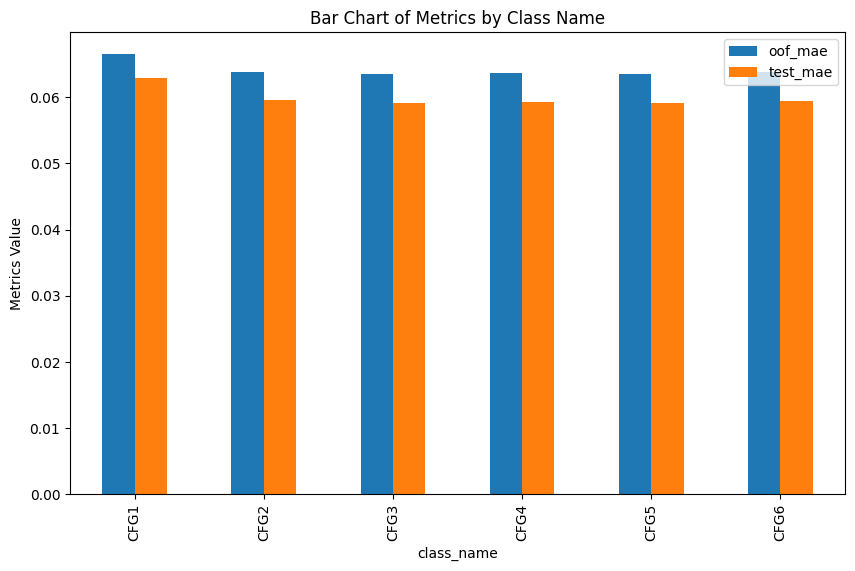

In [32]:
ax = combined_df.plot.bar(x='class_name', y=['oof_mae','test_mae'], figsize=(10, 6))
ax.set_ylabel('Metrics Value')
ax.set_title('Bar Chart of Metrics by Class Name')
plt.show()


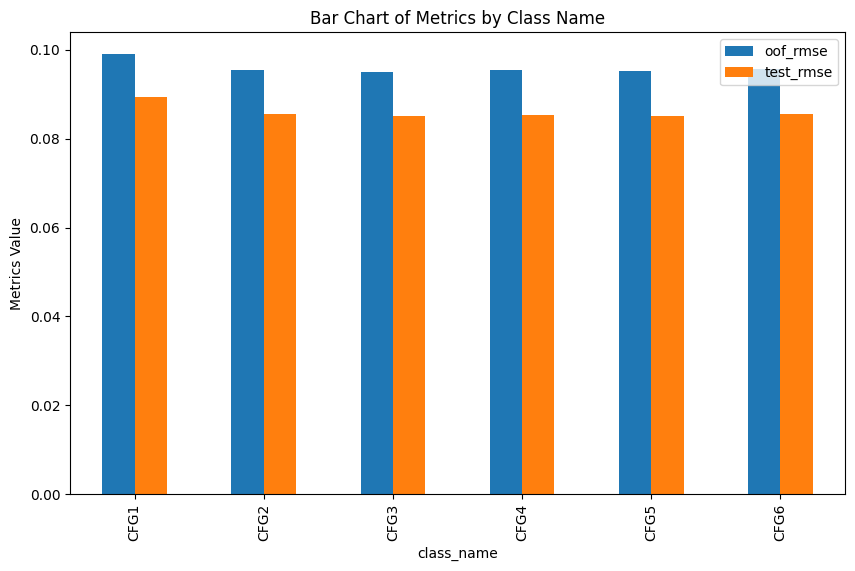

In [33]:
ax = combined_df.plot.bar(x='class_name', y=['oof_rmse', 'test_rmse'], figsize=(10, 6))
ax.set_ylabel('Metrics Value')
ax.set_title('Bar Chart of Metrics by Class Name')
plt.show()


実験2　- 4~6月学習、7月テスト

- CFG7とCFG8~CFG12の比較よりuse_pred_featuresは有効
- CFG12が有効(flo特徴量有効)、ただしCFG8（フロー無し)>CFG11>CFG9 いずれも微差


In [34]:
config_note_name = "LGBM003_config.py"
# 使用するCFGクラス名を指定
usecfg = [f"CFG{i}" for i in range(7, 13)]

# LGBM003_configモジュール内のCFG接頭辞を持つすべてのクラスを取得し、使用するクラスだけをリストに追加
cfg_list = [cls for name, cls in inspect.getmembers(LGBM003_config, inspect.isclass) if name.startswith("CFG") and name in usecfg]

# すべてのCFGクラスをデータフレームに変換し、リストに追加して結合
combined_df = pd.concat([class_to_df(cfg_class) for cfg_class in cfg_list], ignore_index=True)
combined_df["config_note_name"] = config_note_name 

scores = []
oof_list = []
for _oof_path in combined_df.note_num:
    oof_path = "H:/study/output/" + _oof_path + "/oof.csv"
    oof = pd.read_csv(oof_path)

    score_df = pd.DataFrame({"note_num": [_oof_path]})
    for fold,group in oof.groupby("fold"):
        rmse = np.sqrt(utils.compute_mse(group["pred"], group["nv2"]))
        mae = utils.compute_mae(group["pred"], group["nv2"])
        if fold=="test":
            score_df[f"test_rmse"] = [rmse]
            score_df[f"test_mae"] = [mae]
        else:
            score_df[f"fold{fold}_rmse"] = [rmse]
            score_df[f"fold{fold}_mae"] = [mae]
    score_df["oof_rmse"] = np.sqrt(utils.compute_mse(oof.loc[oof.fold!="test","pred"], oof.loc[oof.fold!="test","nv2"]))
    score_df["oof_mae"] = utils.compute_mae(oof.loc[oof.fold!="test","pred"], oof.loc[oof.fold!="test","nv2"])
    scores.append(score_df)

scores = pd.concat(scores)
combined_df = combined_df.merge(scores,on="note_num",how="left")


In [35]:
combined_df[['class_name','oof_rmse', 'oof_mae',"test_rmse","test_mae","use_interpolated_features", "use_pred_features", "use_flo_features", "use_flo_lat_features","use_flo_lon_features", 'config_note_name',"note_num",'test_end_date', 'test_start_date', 'train_end_date',
       'train_start_date']].sort_values(by="test_mae")

,class_name,oof_rmse,oof_mae,test_rmse,test_mae,use_interpolated_features,use_pred_features,use_flo_features,use_flo_lat_features,use_flo_lon_features,config_note_name,note_num,test_end_date,test_start_date,train_end_date,train_start_date
2,CFG12,0.078966,0.051054,0.082376,0.056141,True,True,True,True,True,LGBM003_config.py,StackingOpt/LGBM003/CFG12,201408010000,201407010000,201407010000,201404010000
0,CFG10,0.078987,0.051036,0.082399,0.056338,True,True,False,True,False,LGBM003_config.py,StackingOpt/LGBM003/CFG10,201408010000,201407010000,201407010000,201404010000
4,CFG8,0.078969,0.051352,0.082536,0.056389,True,True,False,False,False,LGBM003_config.py,StackingOpt/LGBM003/CFG8,201408010000,201407010000,201407010000,201404010000
1,CFG11,0.079417,0.051461,0.082605,0.056596,True,True,False,False,True,LGBM003_config.py,StackingOpt/LGBM003/CFG11,201408010000,201407010000,201407010000,201404010000
5,CFG9,0.079163,0.051185,0.082704,0.056660,True,True,True,False,False,LGBM003_config.py,StackingOpt/LGBM003/CFG9,201408010000,201407010000,201407010000,201404010000
3,CFG7,0.085916,0.055765,0.086801,0.059792,True,False,False,False,False,LGBM003_config.py,StackingOpt/LGBM003/CFG7,201408010000,201407010000,201407010000,201404010000


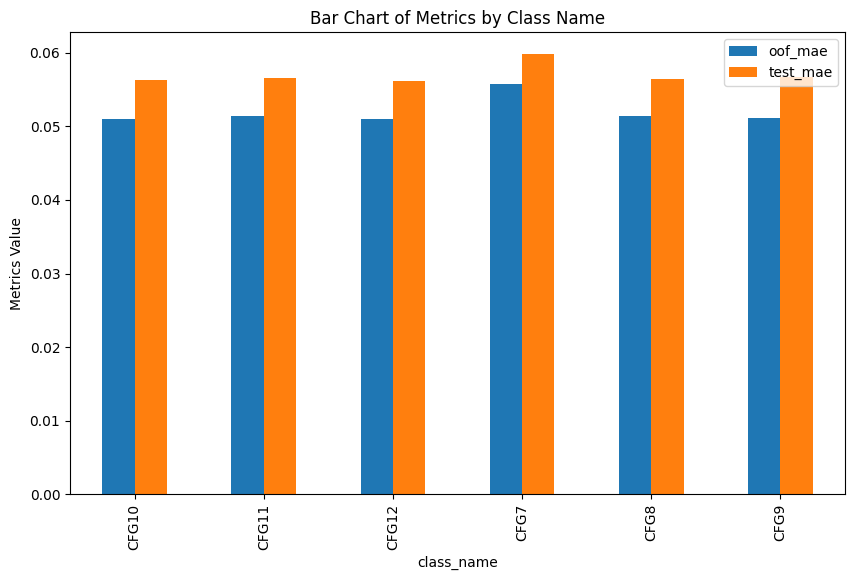

In [36]:
ax = combined_df.plot.bar(x='class_name', y=['oof_mae','test_mae'], figsize=(10, 6))
ax.set_ylabel('Metrics Value')
ax.set_title('Bar Chart of Metrics by Class Name')
plt.show()


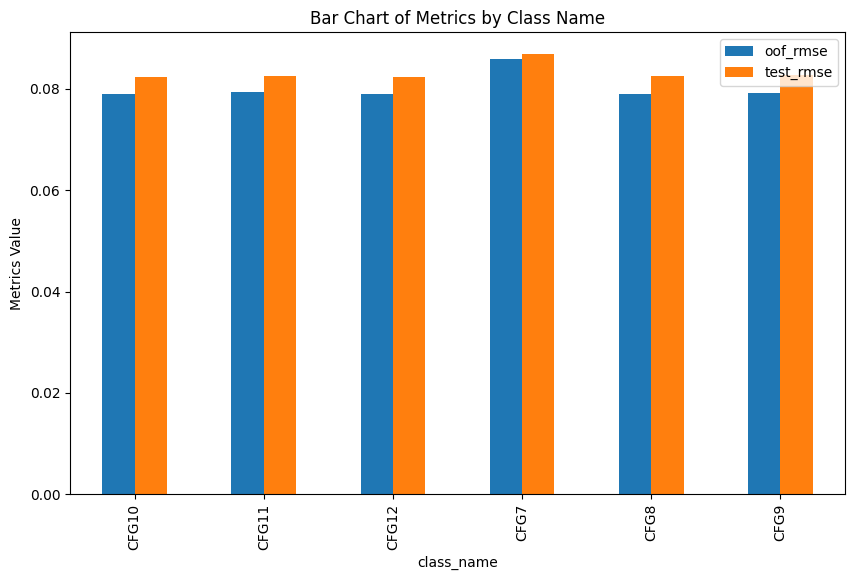

In [37]:
ax = combined_df.plot.bar(x='class_name', y=['oof_rmse', 'test_rmse'], figsize=(10, 6))
ax.set_ylabel('Metrics Value')
ax.set_title('Bar Chart of Metrics by Class Name')
plt.show()


実験1,2で検証月が7月だけ他の月もやる必要がある。オプティカルフローの精度とも比較する